### SELM via PyLAMMPs for Simulations
Author: Paul Atzberger <br>
http://atzberger.org/


In [1]:
import os;
script_base_name = "simulation_polymer4";
script_dir = os.getcwd();

In [2]:
# import the lammps module
try:  
  from selm_lammps.lammps import IPyLammps # use this for the pip install of pre-built package
  lammps_import_comment = "from selm_lammps.lammps import IPyLammps";  
  from selm_lammps import util as atz_util;
except Exception as e:  
  from lammps import IPyLammps # use this for direct install of package
  lammps_import_comment = "from lammps import IPyLammps";
  from atz_lammps import util as atz_util;
except Exception as e: # if fails to import, report the exception   
  print(e);
  lammps_import_comment = "import failed";

import numpy as np;
import matplotlib;
import matplotlib.pyplot as plt;

import sys,shutil,pickle,pdb;

import logging;

fontsize = 14;
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : fontsize};

matplotlib.rc('font', **font);

### Setup SELM Simulation

In [3]:
# @base_dir
base_dir_output   = '%s/output/%s'%(script_dir,script_base_name);
atz_util.create_dir(base_dir_output);

dir_run_name = 'harmonic';
base_dir = '%s/%s_test000'%(base_dir_output,dir_run_name);

# remove all data from dir
atz_util.rm_dir(base_dir);

# setup the directories
base_dir_fig    = '%s/fig'%base_dir;
atz_util.create_dir(base_dir_fig);

base_dir_vtk    = '%s/vtk'%base_dir;
atz_util.create_dir(base_dir_vtk);

# setup logging
# @@@! Setup AtzLogging class and references...
atzLog = atz_util.AtzLogging(print,base_dir);
#atz_util.setup_log(print,base_dir);
print("");

print_log = atzLog.print_log;

# print the import comment
print_log(lammps_import_comment);

# change directory for running LAMMPS in output
print_log("For running LAMMPS changing the current working directory to:\n%s"%base_dir);
os.chdir(base_dir); # base the current working directory
#os.chdir(script_dir); # base the current working directory


Setting up log file in filename = /USER-SELM/examples/Polymer4/output/simulation_polymer4_2/harmonic_test001/main.log

from selm_lammps.lammps import IPyLammps
For running LAMMPS changing the current working directory to:
/USER-SELM/examples/Polymer4/output/simulation_polymer4_2/harmonic_test001


### Setup LAMMPs

In [4]:
L = IPyLammps();
atz_util.print_version_info(L);    

LAMMPS output is captured by PyLammps wrapper
LAMMPS version: 29 Oct 2020 / 20201029
MPI version: LAMMPS MPI STUBS for LAMMPS version 29 Oct 2020


### Copy files to the output directory

In [5]:
# copy the model files to the destination
src = script_dir + '/' + "Model1";
dst = base_dir + '/';
atz_util.copytree2(src,dst,symlinks=False,ignore=None);

print_log("Model files being copied:\n" + "src = " + str(src) + "\n" + "dst = " + str(dst));

Model files being copied:
src = /USER-SELM/examples/Polymer4/Model1
dst = /USER-SELM/examples/Polymer4/output/simulation_polymer4_2/harmonic_test001/


In [6]:
flag_copy_notebook_to_output = True;
if flag_copy_notebook_to_output:
  #cur_dir = os.getcwd();
  #src = cur_dir + '/' + script_base_name + '.ipynb';
  src = script_dir + '/' + script_base_name + '.ipynb';    
  dst = base_dir + '/' + 'archive__' + script_base_name + '.ipynb';
  shutil.copyfile(src, dst);
  print_log("Copying notebook to archive:\n" + "src = " + str(src) + "\n" + "dst = " + str(dst));

Copying notebook to archive:
src = /USER-SELM/examples/Polymer4/simulation_polymer4_2.ipynb
dst = /USER-SELM/examples/Polymer4/output/simulation_polymer4_2/harmonic_test001/archive__simulation_polymer4_2.ipynb


### Common Physical Parameters (nano units)

In [7]:
# Reference units and parameters
units = {'name':'nano','mu':1.0,'rho':0.001,
         'KB':0.01380651,'T':298.15};
units.update({'KBT':units['KB']*units['T']});

### Setup the Simulation Files (such as .read_data)

In [8]:
num_dim = 3;
box = np.zeros((num_dim,2));
LL = 202.5; box[:,0] = -LL; box[:,1] = LL;

# setup atoms
I_id = 1; I_type = 1; atom_types = [];
atom_list = []; atom_mass_list = []; atom_id_list = []; 
atom_mol_list = []; atom_name_list = [];

# polymer atoms
atom_name = "polymer_pts";
atom_name_list.append(atom_name);
atom_types.append(I_type); 

num_pts = 100; 
t = np.linspace(0,2*np.pi,num_pts,endpoint=False); R0 = 40;
x1 = R0*(2.0 + np.cos(2.0*t))*np.cos(3.0*t); 
x2 = R0*(2.0 + np.cos(2.0*t))*np.sin(3.0*t); 
x3 = R0*2*np.sin(4.0*t);
x = np.stack((x1,x2,x3),axis=1); # shape = [num_pts,num_dim]
num_pts = x.shape[0]; m0 = 1.123; 
atom_id = np.arange(I_id + 0,I_id + num_pts,dtype=int);
mol_id = 1; atom_mol = np.ones(num_pts,dtype=int)*mol_id;
atom_list.append(x); atom_mass_list.append(m0); 
atom_id_list.append(atom_id); atom_mol_list.append(atom_mol);
I_type += 1; I_id += num_pts;
print_log("atom_name = " + str(atom_name));
print_log("num_pts = " + str(num_pts));

# tracer atoms
flag_tracer = True;
if flag_tracer:
  atom_name = "tracer_pts";
  atom_name_list.append(atom_name);
  atom_types.append(I_type); 
  atom_types[I_type - 1] = I_type;  
  num_pts_dir = 10; m0 = 1.123; 
  x1 = np.linspace(-LL,LL,num_pts_dir + 1,endpoint=False); dx = x1[1] - x1[0];
  x1 = x1 + 0.5*dx;
  xx = np.meshgrid(x1,x1,x1);
  x = np.stack((xx[0].flatten(),xx[1].flatten(),xx[2].flatten()),axis=1); # shape = [num_pts,num_dim]
  #ipdb.set_trace();
  num_pts = x.shape[0];
  atom_id = np.arange(I_id + 0,I_id + num_pts,dtype=int);
  mol_id = 2; atom_mol = np.ones(x.shape[0],dtype=int)*mol_id;
  atom_list.append(x); atom_mass_list.append(m0); 
  atom_id_list.append(atom_id); atom_mol_list.append(atom_mol);
  I_type += 1; I_id += num_pts;
  print_log("atom_name = " + str(atom_name));
  print_log("num_pts = " + str(num_pts));

# summary data    
# get total number of atoms
atom_types = np.array(atom_types,dtype=int);
num_atoms = I_id - 1; # total number of atoms

# setup bonds
I_id = 1; I_type = 1; bond_types = []; bond_name_list = [];
bond_list = []; bond_coeff_list = []; bond_id_list = [];

flag_bond_1 = True;
if flag_bond_1:
  bond_types.append(I_type);
  #bond_name_list.append("fene_1");
  bond_name_list.append("harmonic_1");
  
  KBT = units['KBT']; ell = 5.0; K = 0.5*KBT/(ell*ell); r0 = 20;
  b = "harmonic %.7f %7f"%(K,r0);
  print_log("bond:");
  print_log("KBT = " + str(KBT)); print_log("r0 = " + str(r0));  
  print_log("bond coeff = " + str(b));
  bond_coeff_list.append(b);

  I0 = atz_util.atz_find_name(atom_name_list,"polymer_pts"); I_atom_type = atom_types[I0];
  atom_id = atom_id_list[I_atom_type - 1]; nn = atom_id.shape[0];
  bonds = np.zeros((nn,2),dtype=int); 
  bond_id = np.zeros(bonds.shape[0],dtype=int);
  for i in range(0,nn):
    i1 = atom_id[i % nn]; i2 = atom_id[(i + 1)%nn];  # base 1 indexing, closed loop
    bonds[i,0] = i1; bonds[i,1] = i2;
    bond_id[i] = I_id;
    I_id += 1;  
  bond_list.append(bonds); bond_id_list.append(bond_id);
  I_type += 1;

# summary data    
num_bonds = I_id - 1;
bond_types = np.array(bond_types,dtype=int);

# setup angles
I_id = 1; I_type =1 ; angle_types = []; angle_name_list = [];
angle_list = []; angle_coeff_list = []; angle_id_list = [];

flag_angles_1 = True;
if flag_angles_1:
  angle_name_list.append("atom_type_1");
  angle_types.append(I_type);
  #KBT = 2478959.87; K = 10*KBT; theta_0 = 180.0; # degrees
  KBT = units['KBT']; K = 5*KBT; theta_0 = 180.0; # degrees
  b = "harmonic %.7f %.7f"%(K,theta_0);
  angle_coeff_list.append(b);

# build angle bonds for type 1 atoms with type 1 atoms, closed loop
if flag_angles_1:
  I0 = atz_util.atz_find_name(atom_name_list,"polymer_pts"); I_atom_type = atom_types[I0];
  atom_id = atom_id_list[I_atom_type - 1]; nn = atom_id.shape[0];
  angles = np.zeros((nn,3),dtype=int);
  angle_id = np.zeros(angles.shape[0],dtype=int);
  for i in range(0,nn):
    i1 = atom_id[i]; i2 = atom_id[(i + 1)%nn]; i3 = atom_id[(i + 2)%nn]; # base 1 indexing
    angles[i,0] = i1; angles[i,1] = i2; angles[i,2] = i3;
    angle_id[i] = I_id; I_id += 1;
  angle_list.append(angles); angle_id_list.append(angle_id);
  I_type += 1;

# summary data    
num_angles = I_id - 1;
angle_types = np.array(angle_types,dtype=int);

# store the model information
model_info = {};
model_info.update({'num_dim':num_dim,'box':box,'atom_types':atom_types,
          'atom_list':atom_list,'atom_mass_list':atom_mass_list,'atom_name_list':atom_name_list,
          'atom_id_list':atom_id_list,'atom_mol_list':atom_mol_list,
          'bond_types':bond_types,'bond_list':bond_list,'bond_id_list':bond_id_list,
          'bond_coeff_list':bond_coeff_list,'bond_name_list':bond_name_list,
          'angle_types':angle_types,'angle_list':angle_list,'angle_id_list':angle_id_list,
          'angle_coeff_list':angle_coeff_list,'angle_name_list':angle_name_list});

atom_name = polymer_pts
num_pts = 100
atom_name = tracer_pts
num_pts = 1331
bond:
KBT = 4.116410956499999
r0 = 20
bond coeff = harmonic 0.0823282 20.000000


In [9]:
# write .pickle data with the model setup information
filename = "model_setup.pickle";
print_log("Writing model data .pickle");
print_log("filename = " + filename);
s = model_info;
f = open(filename,'wb'); pickle.dump(s,f); f.close();

# write the model .read_data file for lammps
filename = "Polymer.LAMMPS_read_data";
print_log("Writing model data .read_data");
print_log("filename = " + filename);
atz_util.write_read_data(filename=filename,print_log=print_log,**model_info);

Writing model data .pickle
filename = model_setup.pickle
Writing model data .read_data
filename = Polymer.LAMMPS_read_data


In [10]:
#!cat Polymer.LAMMPS_read_data

### Perform the simulation

In [11]:
# We can send collection of commands using the triple quote notation
s = """
# =========================================================================
# LAMMPS main parameter file and script                                    
#                                                                          
# Author: Paul J. Atzberger.               
#
# Based on script generated by MANGO-SELM Model Builder.
#                                                                          
# =========================================================================

# == Setup variables for the script 
variable dumpfreq         equal    1
variable restart          equal    0
variable neighborSkinDist equal    1.0 # distance for bins beyond force cut-off (1.0 = 1.0 Ang for units = real) 
variable baseFilename     universe Polymer

# == Setup the log file
#log         ${baseFilename}.LAMMPS_logFile

# == Setup style of the run

# type of units to use in the simulation (units used are in fact: amu, nm, ns, Kelvins)
units       nano

# indicates possible types allowed for interactions between the atoms
atom_style  angle 

# indicates possible types allowed for bonds between the atoms 
bond_style hybrid harmonic 

# indicates possible types allowed for bond angles between the atoms 
angle_style hybrid harmonic

# indicates type of boundary conditions in each direction (p = periodic) 
boundary p p p 

read_data ${baseFilename}.LAMMPS_read_data # file of atomic coordinates and topology
velocity all zero linear                   # initialize all atomic velocities initially to zero

# == Interactions 
pair_style none
atom_modify sort 1000 ${neighborSkinDist}          # setup sort data explicitly since no interactions to set this data. 

# == Setup neighbor list distance
comm_style tiled
comm_modify mode single cutoff 202.0 vel yes

neighbor ${neighborSkinDist} bin                    # first number gives a distance beyond the force cut-off ${neighborSkinDist}
neigh_modify every 1

atom_modify sort 0 ${neighborSkinDist}           # setup sort data explicitly since no interactions to set this data. 

# == Setup the SELM integrator
fix 1 all selm Main.SELM_params

# note langevin just computes forces, nve integrates the motions
#fix 1 all langevin 298.15 298.15 0.00001 48279
#fix 2 all nve

# == Setup output data write to disk
#dump        dmp_dcd all dcd ${dumpfreq} ${baseFilename}_LAMMPS_atomCoords.dcd
#dump_modify dmp_dcd unwrap yes                   # indicates for periodic domains that unwrapped coordinate should be given

dump        dmp_vtk all vtk ${dumpfreq} ./vtk/Particles_*.vtp id type vx fx
dump_modify dmp_vtk pad 8 # ensures filenames file_000000.data

# == simulation time-stepping
timestep 60

"""

# feed commands to LAMMPs one line at a time
print_log("Sending commands to LAMMPs");
for line in s.splitlines():
  print_log(line);
  L.command(line);

Sending commands to LAMMPs

# =========================================================================
# LAMMPS main parameter file and script                                    
#                                                                          
# Author: Paul J. Atzberger.               
#
# Based on script generated by MANGO-SELM Model Builder.
#                                                                          
# =========================================================================

# == Setup variables for the script 
variable dumpfreq         equal    1
variable restart          equal    0
variable neighborSkinDist equal    1.0 # distance for bins beyond force cut-off (1.0 = 1.0 Ang for units = real) 
variable baseFilename     universe Polymer

# == Setup the log file
#log         ${baseFilename}.LAMMPS_logFile

# == Setup style of the run

# type of units to use in the simulation (units used are in fact: amu, nm, ns, Kelvins)
units       nano

# indicates pos

In [12]:
#!cat Model.SELM_Info

save_filename = /USER-SELM/examples/Polymer4/output/simulation_polymer4_2/harmonic_test001/fig/configuration_initial1.pdf
save_filename = /USER-SELM/examples/Polymer4/output/simulation_polymer4_2/harmonic_test001/fig/configuration_initial1.png


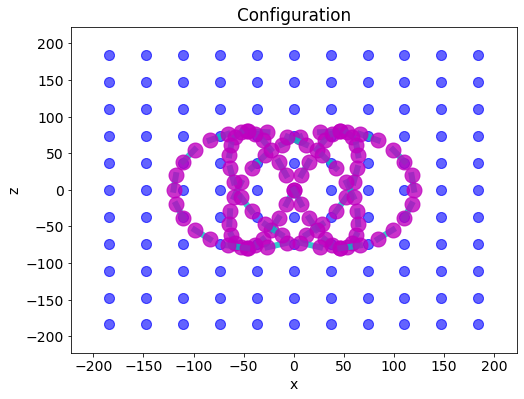

In [13]:
flag_run_cell = True;
if flag_run_cell:
  atoms = L.atoms;
  num_atoms = len(atoms);
  xx = []; tt = [];
  for i in range(0,num_atoms):
    #ii = L.atoms[i].index;
    xx.append(atoms[i].position);
    tt.append(atoms[i].type); 

  atom_x = np.array(xx); # convert to numpy array
  atom_type = np.array(tt);
    
  plt.figure(1,facecolor='white',figsize= (8,6));

  II = np.nonzero(atom_type == 2)[0]
  plt.plot(atom_x[II,0],atom_x[II,2],'b.',ms=20,alpha=0.08);

  II = np.nonzero(atom_type == 1)[0];
  for ii in range(0,int(len(II)/2)):
    III = [II[2*ii],II[2*ii+1]];
    X1 = atom_x[II[0],:]; X2 = atom_x[II[1],:];
    dist = np.sqrt(np.sum(np.power(X1 - X2,2))); ell = 1.99*LL;
    if dist <= ell:
      plt.plot(atom_x[III,0],atom_x[III,2],'c-',lw=6,alpha=0.8);
    plt.plot(atom_x[III[0],0],atom_x[III[0],2],'m.',ms=30,alpha=0.8);
    plt.plot(atom_x[III[1],0],atom_x[III[1],2],'m.',ms=30,alpha=0.8);
    
  #plt.plot(atom_x[II,0],atom_x[II,2],'m.',ms=50,alpha=0.8);

  plt.xlabel('x');
  plt.ylabel('z');
  plt.xlim([-1.1*LL,1.1*LL]);
  plt.ylim([-1.1*LL,1.1*LL]);
  #plt.title('Configuration t=%.3g'%);
  plt.title('Configuration');

  plt.draw();
  base_filename = '%s/configuration_initial1'%(base_dir_fig);
  atz_util.save_fig(base_filename,flag_pdf=True);


In [ ]:
# We can send collection of commands using the triple quote notation
s = """
# == Run the simulation
run      1000 upto

# == Write restart data
write_restart ${baseFilename}.LAMMPS_restart_data
"""

# feed commands to LAMMPs one line at a time
print_log("Sending commands to LAMMPs");
for line in s.splitlines():
  print_log(line);
  L.command(line);

Sending commands to LAMMPs

# == Run the simulation
run      1000 upto


### Get the last configuration

In [ ]:
print_log("L.fixes = " + str(L.fixes));

print_log("");
print_log("Run additional steps (method 1):")
print_log("L.run(num_steps)");
num_steps = 10;
#L.run(num_steps);

print_log("");
print_log("Run additional steps (method 2):")
num_steps = 10;
s = "run %d"%num_steps;
print_log("L.command(\"%s\");"%s);
#L.command(s);

print_log("");
print_log("Atom positions:")
# Get the atom current location
atoms = L.atoms;
num_atoms = len(atoms);
xx = []; tt = [];
for i in range(0,num_atoms):
  #ii = L.atoms[i].index;
  xx.append(atoms[i].position);
  tt.append(atoms[i].type); 

atom_x = np.array(xx); # convert to numpy array
atom_type = np.array(tt);

print_log("atom_x = " + str(atom_x));
print_log("atom_type = " + str(atom_type));

### Plot the last configuration

In [ ]:
flag_run_cell = True;
if flag_run_cell:
  plt.figure(1,facecolor='white',figsize= (8,6));

  II = np.nonzero(atom_type == 2)[0]
  plt.plot(atom_x[II,0],atom_x[II,2],'b.',ms=50,alpha=0.08);

  II = np.nonzero(atom_type == 1)[0];
  for ii in range(0,int(len(II)/2)):
    III = [II[2*ii],II[2*ii+1]];
    X1 = atom_x[II[0],:]; X2 = atom_x[II[1],:];
    dist = np.sqrt(np.sum(np.power(X1 - X2,2))); ell = 1.99*LL;
    if dist <= ell:
      plt.plot(atom_x[III,0],atom_x[III,2],'c-',lw=7,alpha=0.8);
    plt.plot(atom_x[III[0],0],atom_x[III[0],2],'m.',ms=50,alpha=0.8);
    plt.plot(atom_x[III[1],0],atom_x[III[1],2],'m.',ms=50,alpha=0.8);
    
  #plt.plot(atom_x[II,0],atom_x[II,2],'m.',ms=50,alpha=0.8);

  plt.xlabel('x');
  plt.ylabel('z');
  #plt.title('Configuration t=%.3g'%);
  plt.title('Configuration');

  plt.draw();
  base_filename = '%s/configuration_view1'%(base_dir_fig);
  atz_util.save_fig(base_filename,flag_pdf=True);



In [ ]:
print_log("Done");

### Misc codes

In [ ]:
flag_run_cell = False;
if flag_run_cell:
  # For VMD visualization file, 
  # copy these commands into the .vmd file near the end
  s = "";
  for i in range(0,x.shape[0]-1):
    s += "topo addbond %d %d \n"%(i,i+1);

  print(s);
